In [8]:
import numpy as np
import matplotlib.pyplot as plt 
import time
from typing import Tuple
import networkx as nx  # for plotting Graphs

from ba_graph import * 

# Task 1 

Zadanie 1 Model rosnącego grafu scale-free: Barab ́asi-Albert (BA)

In [5]:
graph_sizes = [(100,3), (1000,3), (10000,2), (10000,3), (1000000,3)]
print(graph_sizes[0][0], graph_sizes[0][1])

100 3


In [22]:
def build_BA_graph(size: Tuple[int, int]):
    ba = BarabasiAlbertGraph(n=size[0], m=size[1], compute_connections=(size[0]<=1000))
    ba.build_graph()
    degrees = ba.get_degrees()

    x, y = np.unique(degrees, return_counts=True)
    plt.loglog(x, y, marker='.')

    y_thresh = 2 # or 3

    #polyfit for linear regression:
    x_fit, y_fit = np.log10(x)[y > y_thresh], np.log10(y)[y > y_thresh]
    a, b = np.polyfit(x_fit, y_fit, 1)
    plt.plot([10 ** x_fit[0], 10 ** x_fit[-1]], [10 ** (x_fit[0] * a + b), 10 ** (x_fit[-1] * a + b)])

    plt.title(f'Degree distribution for n={size[0]}, m={size[1]}; a={a:0.3f}')
    plt.xlabel('Degree (log)')
    plt.ylabel('Count (log)')
    plt.show()

    # Create Graph plots only for small ones:
    if size[0] <= 1000:
        G = nx.from_dict_of_lists(ba.connections)



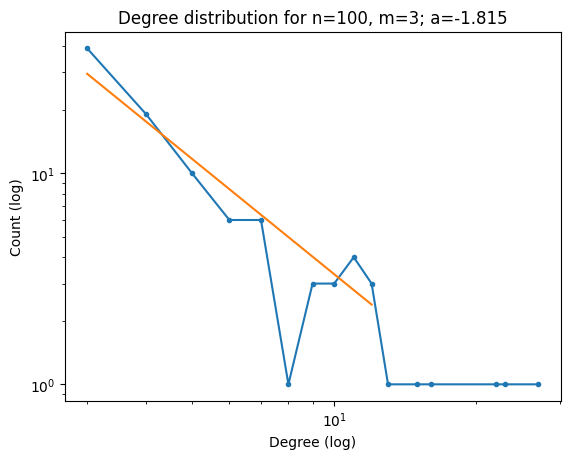

In [21]:
G0_size = graph_sizes[0]

build_BA_graph(G0_size)

## Knowledge sources and inspirations:

As a main source of inspiration for this source is 